In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qSMLM.psf.psf2d.psf2d import *
from scipy.special import comb

In [138]:
class Generator:
    def __init__(self):
        pass

class Mix2D_Ring(Generator):
    def __init__(self,config):
        super().__init__()
        self.config = config
        
    def _mu(self,theta,npixels,patch_hw=5):
        x = np.arange(0,2*patch_hw); y = np.arange(0,2*patch_hw)
        X,Y = np.meshgrid(x,y)
        srate = np.zeros((npixels,npixels),dtype=np.float32)
        for n in range(self.config['particles']):
            x0,y0,sigma,N0 = theta[:,n]
            patchx, patchy = int(round(x0))-patch_hw, int(round(y0))-patch_hw
            x0p = x0-patchx; y0p = y0-patchy
            lam = lamx(X,x0p,sigma)*lamy(Y,y0p,sigma)
            mu = self.config['eta']*N0*lam
            srate[patchx:patchx+2*patch_hw,patchy:patchy+2*patch_hw] += mu
        return srate
        
    def ring(self,n,radius=3,phase=0):
        thetas = np.arange(0,n,1)*2*np.pi/n
        xs = radius*np.cos(thetas+phase)
        ys = radius*np.sin(thetas+phase)
        return xs,ys
    
    def pmatrix(self,theta,patch_hw=5):
        
        x = np.arange(0,2*patch_hw); y = np.arange(0,2*patch_hw)
        X,Y = np.meshgrid(x,y)
        npixels = self.config['npixels']
        nparticles = self.config['particles']
        P = np.zeros((nparticles, npixels*npixels))
        for n in range(nparticles):
            mu = np.zeros((npixels,npixels),dtype=np.float32)
            x0,y0,sigma,N0 = theta[:,n]
            patchx, patchy = int(round(x0))-patch_hw, int(round(y0))-patch_hw
            x0p = x0-patchx; y0p = y0-patchy
            lam = lamx(X,x0p,sigma)*lamy(Y,y0p,sigma)
            mu[patchx:patchx+2*patch_hw,patchy:patchy+2*patch_hw] += lam
            P[n,:] = mu.flatten()
        return P
    
    def computeB(self,nparticles,K):
        binary_array = np.array([1] * K + [0] * (nparticles - K), dtype=int)
        B = np.array(list(set(itertools.permutations(binary_array, nparticles))))
        return B.T

    def forward(self,r=4,show=False,patch_hw=5,ring_radius=10):
        theta = np.zeros((4,self.config['particles']))
        nx,ny = self.config['npixels'],self.config['npixels']
        xsamp,ysamp = self.ring(self.config['particles'],radius=ring_radius)
        x0 = nx/2; y0 = ny/2
        theta[0,:] = xsamp + x0
        theta[1,:] = ysamp + y0
        theta[2,:] = self.config['sigma']
        theta[3,:] = self.config['N0']
        mu = self._mu(theta,self.config['npixels'],patch_hw=patch_hw)
        
        npixels = self.config['npixels']
        Kmax = 3; #single photon counts only
        Omega = np.zeros((Kmax+1,npixels**2))
        for K in range(Kmax+1):
            Nck = comb(self.config['particles'],K)
            P = self.pmatrix(theta) # nparticles, npixels**2 (columns are probs emitters emit into that pixel)
            B = self.computeB(self.config['particles'],K) # nparticles, Nck
            P = np.repeat(P[:,:,np.newaxis],Nck,axis=2) #nparticles, npixels**2, Nck
            B = np.repeat(B[:,np.newaxis,:],npixels**2,axis=1) #nparticles, npixels**2, Nck
            R = np.power(P,B)*np.power(1-P,1-B)
            R = np.sum(np.prod(R,axis=0),axis=1)
            Omega[K,:] = R
       
        Chi = np.arange(0,Kmax+1,1)
        Chi = np.repeat(Chi[:,np.newaxis],npixels**2,axis=1)
        E = np.sum(Chi*Omega,axis=0)  #<XY> = <X><Y>
        return mu

    def show(self,theta,mu):
        fig,ax=plt.subplots(1,2)
        ax[0].scatter(theta[1,:],theta[0,:],color='black',s=5)
        ax[0].set_aspect(1.0)
        ax[1].imshow(mu,cmap=plt.cm.BuGn_r)
        ax[0].set_xlim([0,self.config['npixels']])
        ax[0].set_ylim([0,self.config['npixels']])
        ax[0].invert_yaxis()
        plt.show()

In [139]:
config = {
    "particles": 7,
    "npixels": 20,
    "sigma": 0.92,
    "N0": 0.5,
    "eta": 1.0}

mix2d = Mix2D_Ring(config)
mu = mix2d.forward(show=True,ring_radius=config['npixels']/5)

In [29]:
npixels = 3
x = np.ones((npixels**2,))
mask = np.arange(len(x)) % npixels == 0
x[mask] = 0; x = np.roll(x,-1)
A = np.diag(x,k=1) #horizontally adjacent
B = np.diag(x,k=-1) #vertically adjacent

x = np.ones((npixels**2-npixels,))
mask = np.arange(len(x)) % npixels == 0
x[mask] = 0; x = np.roll(x,-1)
C = np.diag(x,k=npixels+1) #right diagonal
D = np.diag(x,k=-npixels-1) #left diagonal

In [35]:
Aind = np.where(A > 0)
Bind = np.where(B > 0)
Cind = np.where(C > 0)
Dind = np.where(D > 0)

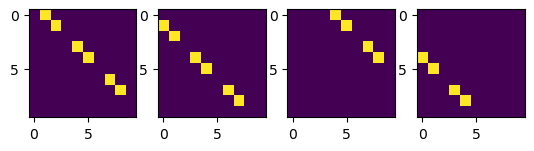

In [36]:
fig,ax=plt.subplots(1,4)
ax[0].imshow(A)
ax[1].imshow(B)
ax[2].imshow(C)
ax[3].imshow(D)
plt.show()